# Problem statement
This is week 4 of Kaggle's COVID19 forecasting series.

Here we also forecast each country's recovery rate. If forecasted recoveries > forecasted confirmed cases, this means the curve for forecasted confirmedcases have flattened and will be adjusted. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time

from datetime import timedelta
from sklearn.linear_model import LinearRegression

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/covid19-global-forecasting-week-4/train.csv
/kaggle/input/covid19-global-forecasting-week-4/submission.csv
/kaggle/input/covid19-global-forecasting-week-4/test.csv


In [2]:
N = 3 # Number of previous data points to use to forecast

# Common functions

In [3]:
def get_preds_lin_reg(series, pred_min, H):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        series     : series to forecast
        pred_min   : all predictions should be >= pred_min
        H          : forecast horizon
    Outputs
        result: the predictions. The length of result is H. numpy array of shape (H,)
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    X_train = np.array(range(len(series))) # e.g. [0 1 2 3 4]
    y_train = np.array(series) # e.g. [2944 3088 3226 3335 3436]
    X_train = X_train.reshape(-1, 1)     # e.g X_train = 
                                             # [[0]
                                             #  [1]
                                             #  [2]
                                             #  [3]
                                             #  [4]]
    # X_train = np.c_[np.ones(N), X_train]              # add a column
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)            # Train the model
    pred = regr.predict(np.array(range(len(series),len(series)+H)).reshape(-1,1))
    pred = pred.reshape(H,)
    
    # If the values are < pred_min, set it to be pred_min
    pred[pred < pred_min] = pred_min
        
    return np.around(pred)

# Load data

In [4]:
train = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/train.csv')

# Change column names to lower case
train.columns = [col.lower() for col in train.columns]

# Change to date format
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')

train

,id,province_state,country_region,date,confirmedcases,fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
28165,35654,NaN,Zimbabwe,2020-04-16,23.0,3.0
28166,35655,NaN,Zimbabwe,2020-04-17,24.0,3.0
28167,35656,NaN,Zimbabwe,2020-04-18,25.0,3.0
28168,35657,NaN,Zimbabwe,2020-04-19,25.0,3.0


In [5]:
test = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/test.csv')

# Change column names to lower case
test.columns = [col.lower() for col in test.columns]

# Change to date format
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')

test

,forecastid,province_state,country_region,date
0,1,NaN,Afghanistan,2020-04-02
1,2,NaN,Afghanistan,2020-04-03
2,3,NaN,Afghanistan,2020-04-04
3,4,NaN,Afghanistan,2020-04-05
4,5,NaN,Afghanistan,2020-04-06
...,...,...,...,...
13454,13455,NaN,Zimbabwe,2020-05-10
13455,13456,NaN,Zimbabwe,2020-05-11
13456,13457,NaN,Zimbabwe,2020-05-12
13457,13458,NaN,Zimbabwe,2020-05-13


In [6]:
submission = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/submission.csv')
submission

,ForecastId,ConfirmedCases,Fatalities
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1
...,...,...,...
13454,13455,1,1
13455,13456,1,1
13456,13457,1,1
13457,13458,1,1


# Load recoveries data

In [7]:
# Get recovery data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recov = pd.read_csv(url, error_bad_lines=False)
recov

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,32,32,32,40,43,54,99,112,131,135
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,197,217,232,248,251,277,283,302,314,327
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,460,591,601,691,708,783,846,894,1047,1099
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,71,128,128,128,169,169,191,205,235,248
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,4,4,4,5,5,5,5,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
247,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Convert recoveries to the right format
province_state = []
country_region = []
date = []
recoveries = []

dates = list(recov.columns[4:])
for index, row in recov.iterrows():
    province_state = province_state + [row['Province/State']]*len(dates)
    country_region = country_region + [row['Country/Region']]*len(dates)
    date = date + dates
    recoveries = recoveries + list(row[4:])
    
recoveries_df = pd.DataFrame({'province_state': province_state,
                              'country_region': country_region,
                              'date': date,
                              'recoveries': recoveries})

# Change to date format
recoveries_df['date'] = pd.to_datetime(recoveries_df['date'], format='%m/%d/%y')

recoveries_df

,province_state,country_region,date,recoveries
0,NaN,Afghanistan,2020-01-22,0
1,NaN,Afghanistan,2020-01-23,0
2,NaN,Afghanistan,2020-01-24,0
3,NaN,Afghanistan,2020-01-25,0
4,NaN,Afghanistan,2020-01-26,0
...,...,...,...,...
22495,NaN,Yemen,2020-04-16,0
22496,NaN,Yemen,2020-04-17,0
22497,NaN,Yemen,2020-04-18,0
22498,NaN,Yemen,2020-04-19,0


In [9]:
# Merge recoveries_df with train and test sets
train_merged = train.merge(recoveries_df,
                           left_on=['province_state', 'country_region', 'date'], 
                           right_on=['province_state', 'country_region', 'date'], 
                           how='left')
train = train_merged
train

,id,province_state,country_region,date,confirmedcases,fatalities,recoveries
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0,0.0
...,...,...,...,...,...,...,...
28165,35654,NaN,Zimbabwe,2020-04-16,23.0,3.0,1.0
28166,35655,NaN,Zimbabwe,2020-04-17,24.0,3.0,2.0
28167,35656,NaN,Zimbabwe,2020-04-18,25.0,3.0,2.0
28168,35657,NaN,Zimbabwe,2020-04-19,25.0,3.0,2.0


In [10]:
test

,forecastid,province_state,country_region,date
0,1,NaN,Afghanistan,2020-04-02
1,2,NaN,Afghanistan,2020-04-03
2,3,NaN,Afghanistan,2020-04-04
3,4,NaN,Afghanistan,2020-04-05
4,5,NaN,Afghanistan,2020-04-06
...,...,...,...,...
13454,13455,NaN,Zimbabwe,2020-05-10
13455,13456,NaN,Zimbabwe,2020-05-11
13456,13457,NaN,Zimbabwe,2020-05-12
13457,13458,NaN,Zimbabwe,2020-05-13


# EDA

In [11]:
# Count number of nulls for each column
train.isnull().sum(axis=0)

id                    0
province_state    16200
country_region        0
date                  0
confirmedcases        0
fatalities            0
recoveries         5940
dtype: int64

In [12]:
# Get the province_states
print(len(train['province_state'].unique()))
train['province_state'].unique()

134


array([nan, 'Australian Capital Territory', 'New South Wales',
       'Northern Territory', 'Queensland', 'South Australia', 'Tasmania',
       'Victoria', 'Western Australia', 'Alberta', 'British Columbia',
       'Manitoba', 'New Brunswick', 'Newfoundland and Labrador',
       'Northwest Territories', 'Nova Scotia', 'Ontario',
       'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon', 'Anhui',
       'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi',
       'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hong Kong',
       'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu', 'Jiangxi', 'Jilin',
       'Liaoning', 'Macau', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong',
       'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Xinjiang',
       'Yunnan', 'Zhejiang', 'Faroe Islands', 'Greenland',
       'French Guiana', 'French Polynesia', 'Guadeloupe', 'Martinique',
       'Mayotte', 'New Caledonia', 'Reunion', 'Saint Barthelemy',
       'Saint Pierre and Miqu

In [13]:
# Get the country_regions
print(len(train['country_region'].unique()))
train['country_region'].unique()

184


array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guinea', 'Guine

In [14]:
# Get amount of data per country
train['country_region'].value_counts()

US                4860
China             2970
Canada            1080
United Kingdom     990
France             990
                  ... 
Kyrgyzstan          90
Belize              90
Nepal               90
Mongolia            90
Barbados            90
Name: country_region, Length: 184, dtype: int64

Different country_regions have different amount of data

In [15]:
train[train['country_region']=='Singapore']

,id,province_state,country_region,date,confirmedcases,fatalities,recoveries
19440,24625,NaN,Singapore,2020-01-22,0.0,0.0,0.0
19441,24626,NaN,Singapore,2020-01-23,1.0,0.0,0.0
19442,24627,NaN,Singapore,2020-01-24,3.0,0.0,0.0
19443,24628,NaN,Singapore,2020-01-25,3.0,0.0,0.0
19444,24629,NaN,Singapore,2020-01-26,4.0,0.0,0.0
...,...,...,...,...,...,...,...
19525,24710,NaN,Singapore,2020-04-16,4427.0,10.0,683.0
19526,24711,NaN,Singapore,2020-04-17,5050.0,11.0,708.0
19527,24712,NaN,Singapore,2020-04-18,5992.0,11.0,740.0
19528,24713,NaN,Singapore,2020-04-19,6588.0,11.0,768.0


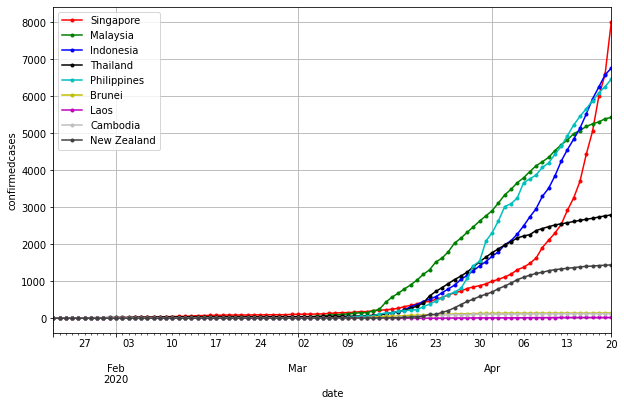

In [16]:
# Plot the confirmed cases in Singapore, Malaysia, Indonesia, Thailand
countries_list = ['Singapore', 'Malaysia', 'Indonesia', 'Thailand', 'Philippines', 'Brunei', 'Laos', 'Cambodia', 'New Zealand']
color_list = ['r', 'g', 'b', 'k', 'c', 'y', 'm', '0.75', '0.25']

ax = train[train['country_region']==countries_list[0]].plot(x='date', y='confirmedcases', style = 'r.-', grid=True, figsize=(10, 6))

i = 1
for country in countries_list[1:]:
    ax = train[train['country_region']==country].plot(x='date', y='confirmedcases', color=color_list[i], marker='.', grid=True, ax=ax, figsize=(10, 6))
    i = i + 1
    
ax.set_xlabel("date")
ax.set_ylabel("confirmedcases")
ax.legend(countries_list)

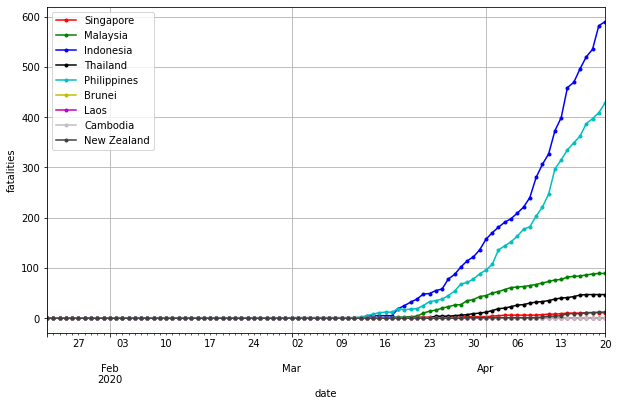

In [17]:
# Plot the fatalities in Singapore, Malaysia, Indonesia, Thailand
ax = train[train['country_region']==countries_list[0]].plot(x='date', y='fatalities', style = 'r.-', grid=True, figsize=(10, 6))

i = 1
for country in countries_list[1:]:
    ax = train[train['country_region']==country].plot(x='date', y='fatalities', color=color_list[i], marker='.', grid=True, ax=ax, figsize=(10, 6))
    i = i + 1
    
ax.set_xlabel("date")
ax.set_ylabel("fatalities")
ax.legend(countries_list)

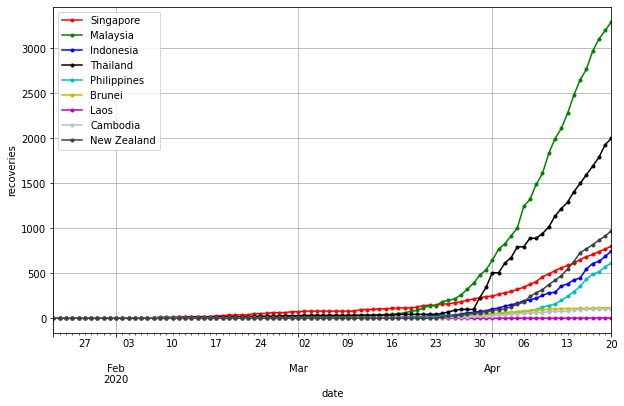

In [18]:
# Plot the recoveries in Singapore, Malaysia, Indonesia, Thailand
ax = train[train['country_region']==countries_list[0]].plot(x='date', y='recoveries', style = 'r.-', grid=True, figsize=(10, 6))

i = 1
for country in countries_list[1:]:
    ax = train[train['country_region']==country].plot(x='date', y='recoveries', color=color_list[i], marker='.', grid=True, ax=ax, figsize=(10, 6))
    i = i + 1
    
ax.set_xlabel("date")
ax.set_ylabel("recoveries")
ax.legend(countries_list)

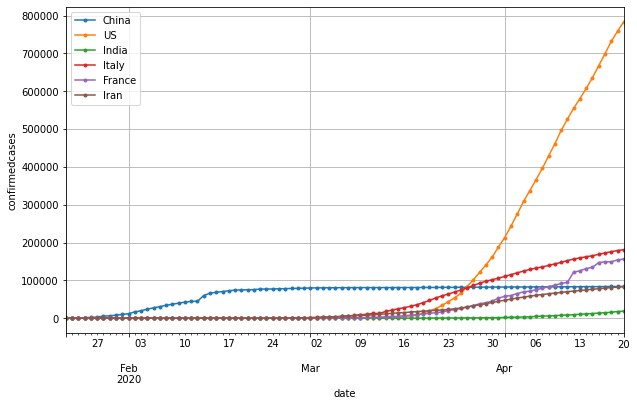

In [19]:
# Plot the confirmed cases in China, US, India
ax = train[train['country_region']=='China'].groupby("date").agg({"confirmedcases": "sum"}).plot(marker='.', figsize=(10, 6), grid=True)
ax = train[train['country_region']=='US'].groupby("date").agg({"confirmedcases": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)
ax = train[train['country_region']=='India'].groupby("date").agg({"confirmedcases": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)
ax = train[train['country_region']=='Italy'].groupby("date").agg({"confirmedcases": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)
ax = train[train['country_region']=='France'].groupby("date").agg({"confirmedcases": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)
ax = train[train['country_region']=='Iran'].groupby("date").agg({"confirmedcases": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)

ax.set_xlabel("date")
ax.set_ylabel("confirmedcases")
ax.legend(['China', 'US', 'India', 'Italy', 'France', 'Iran'])

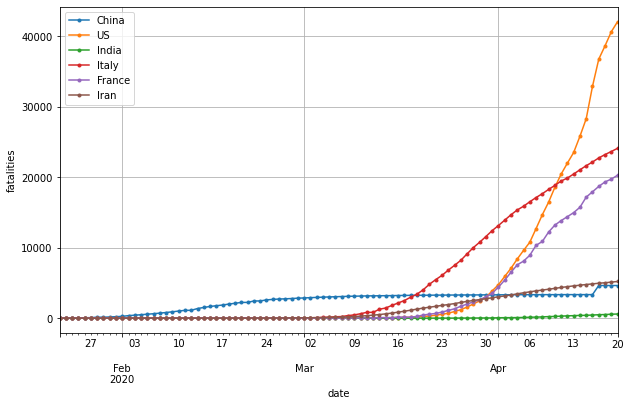

In [20]:
# Plot the fatalities in China, US, India
ax = train[train['country_region']=='China'].groupby("date").agg({"fatalities": "sum"}).plot(marker='.', figsize=(10, 6), grid=True)
ax = train[train['country_region']=='US'].groupby("date").agg({"fatalities": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)
ax = train[train['country_region']=='India'].groupby("date").agg({"fatalities": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)
ax = train[train['country_region']=='Italy'].groupby("date").agg({"fatalities": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)
ax = train[train['country_region']=='France'].groupby("date").agg({"fatalities": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)
ax = train[train['country_region']=='Iran'].groupby("date").agg({"fatalities": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)

ax.set_xlabel("date")
ax.set_ylabel("fatalities")
ax.legend(['China', 'US', 'India', 'Italy', 'France', 'Iran'])

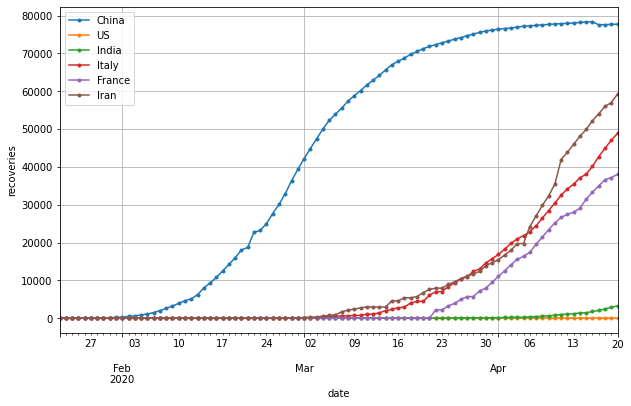

In [21]:
# Plot the recoveries in China, US, India
ax = train[train['country_region']=='China'].groupby("date").agg({"recoveries": "sum"}).plot(marker='.', figsize=(10, 6), grid=True)
ax = train[train['country_region']=='US'].groupby("date").agg({"recoveries": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)
ax = train[train['country_region']=='India'].groupby("date").agg({"recoveries": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)
ax = train[train['country_region']=='Italy'].groupby("date").agg({"recoveries": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)
ax = train[train['country_region']=='France'].groupby("date").agg({"recoveries": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)
ax = train[train['country_region']=='Iran'].groupby("date").agg({"recoveries": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)

ax.set_xlabel("date")
ax.set_ylabel("recoveries")
ax.legend(['China', 'US', 'India', 'Italy', 'France', 'Iran'])

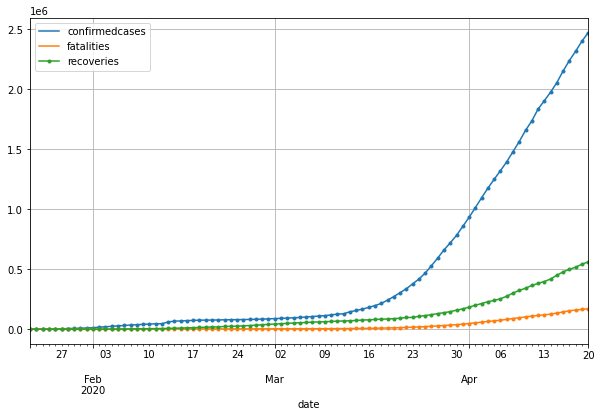

In [22]:
# Get global number of cases
ax = train.groupby("date").agg({"confirmedcases": "sum"}).plot(marker='.', figsize=(10, 6), grid=True)
train.groupby("date").agg({"fatalities": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)
train.groupby("date").agg({"recoveries": "sum"}).plot(marker='.', figsize=(10, 6), grid=True, ax=ax)

# Pre-process train, test

In [23]:
# Fill nans in province_state with ''
train['province_state'] = train['province_state'].fillna(value = 'nil')
train.head()

,id,province_state,country_region,date,confirmedcases,fatalities,recoveries
0,1,nil,Afghanistan,2020-01-22,0.0,0.0,0.0
1,2,nil,Afghanistan,2020-01-23,0.0,0.0,0.0
2,3,nil,Afghanistan,2020-01-24,0.0,0.0,0.0
3,4,nil,Afghanistan,2020-01-25,0.0,0.0,0.0
4,5,nil,Afghanistan,2020-01-26,0.0,0.0,0.0


In [24]:
# Fill nans in recoveries with 0
train['recoveries'] = train['recoveries'].fillna(value = 0)
train.head()

,id,province_state,country_region,date,confirmedcases,fatalities,recoveries
0,1,nil,Afghanistan,2020-01-22,0.0,0.0,0.0
1,2,nil,Afghanistan,2020-01-23,0.0,0.0,0.0
2,3,nil,Afghanistan,2020-01-24,0.0,0.0,0.0
3,4,nil,Afghanistan,2020-01-25,0.0,0.0,0.0
4,5,nil,Afghanistan,2020-01-26,0.0,0.0,0.0


In [25]:
# Fill nans in province_state with ''
test['province_state'] = test['province_state'].fillna(value = 'nil')
test.head()

,forecastid,province_state,country_region,date
0,1,nil,Afghanistan,2020-04-02
1,2,nil,Afghanistan,2020-04-03
2,3,nil,Afghanistan,2020-04-04
3,4,nil,Afghanistan,2020-04-05
4,5,nil,Afghanistan,2020-04-06


In [26]:
# Get unique combinations of province_state and country_region
ps_cr_unique = train[['province_state', 'country_region']].drop_duplicates()
ps_cr_unique

,province_state,country_region
0,nil,Afghanistan
90,nil,Albania
180,nil,Algeria
270,nil,Andorra
360,nil,Angola
...,...,...
27720,nil,Vietnam
27810,nil,West Bank and Gaza
27900,nil,Western Sahara
27990,nil,Zambia


In [27]:
# Get number of days we need to predict
date_max_train = train[(train['province_state']=='nil') & 
                 (train['country_region']=='Singapore')]['date'].max()

date_max_test = test[(test['province_state']=='nil') & 
                 (test['country_region']=='Singapore')]['date'].max()

pred_days = (date_max_test - date_max_train).days
print(date_max_train, date_max_test, pred_days)

2020-04-20 00:00:00 2020-05-14 00:00:00 24


# Prediction for one country

In [28]:
# Specify the country here
ps = 'nil'
cr = 'Singapore'
# ps = 'South Australia'
# cr = 'Australia'

In [29]:
train_sgp = train[(train['province_state']==ps) & (train['country_region']==cr)]
train_sgp[-5:]

,id,province_state,country_region,date,confirmedcases,fatalities,recoveries
19525,24710,nil,Singapore,2020-04-16,4427.0,10.0,683.0
19526,24711,nil,Singapore,2020-04-17,5050.0,11.0,708.0
19527,24712,nil,Singapore,2020-04-18,5992.0,11.0,740.0
19528,24713,nil,Singapore,2020-04-19,6588.0,11.0,768.0
19529,24714,nil,Singapore,2020-04-20,8014.0,11.0,801.0


In [30]:
# Get predictions 
preds = get_preds_lin_reg(train_sgp['confirmedcases'][-N:], 0, pred_days)
preds

array([ 8887.,  9898., 10909., 11920., 12931., 13942., 14953., 15964.,
       16975., 17986., 18997., 20008., 21019., 22030., 23041., 24052.,
       25063., 26074., 27085., 28096., 29107., 30118., 31129., 32140.])

In [31]:
# Put into dataframe
date_list = []
date = pd.date_range(date_max_train+timedelta(days=1), date_max_test)
results = pd.DataFrame({'date': date, 'preds':preds})
results.head()

,date,preds
0,2020-04-21,8887.0
1,2020-04-22,9898.0
2,2020-04-23,10909.0
3,2020-04-24,11920.0
4,2020-04-25,12931.0


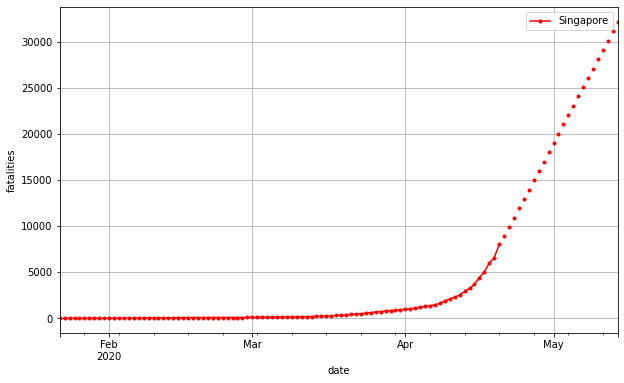

In [32]:
# Plot the confirmed cases in Singapore and the predictions
ax = train[(train['province_state']==ps) & (train['country_region']==cr)].plot(x='date', y='confirmedcases', style = 'r.-', grid=True, figsize=(10, 6))
ax = results.plot(x='date', y='preds', style = 'r.', grid=True, figsize=(10, 6), ax=ax)
    

ax.set_xlabel("date")
ax.set_ylabel("fatalities")
ax.legend([cr])

# Predictions for confirmedcases

In [33]:
# Predict for confirmedcases
ps_list = []
cr_list = []
date_list = []
confirmedcasespred_list = []

for index, row in ps_cr_unique.iterrows():
    train_temp = train[(train['province_state']==row['province_state']) & (train['country_region']==row['country_region'])]
    preds = get_preds_lin_reg(train_temp['confirmedcases'][-N:], 0, pred_days)
    
    ps_list = ps_list + ([row['province_state']]*pred_days)
    cr_list = cr_list + ([row['country_region']]*pred_days)
    date_list = date_list + list(pd.date_range(date_max_train+timedelta(days=1), date_max_test).strftime("%Y-%m-%d"))
    confirmedcasespred_list = confirmedcasespred_list + list(preds)

results = pd.DataFrame({'province_state': ps_list,
                        'country_region': cr_list,
                        'date': date_list,
                        'confirmedcases': confirmedcasespred_list})
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
results

,province_state,country_region,date,confirmedcases
0,nil,Afghanistan,2020-04-21,1078.0
1,nil,Afghanistan,2020-04-22,1124.0
2,nil,Afghanistan,2020-04-23,1171.0
3,nil,Afghanistan,2020-04-24,1218.0
4,nil,Afghanistan,2020-04-25,1264.0
...,...,...,...,...
7507,nil,Zimbabwe,2020-05-10,25.0
7508,nil,Zimbabwe,2020-05-11,25.0
7509,nil,Zimbabwe,2020-05-12,25.0
7510,nil,Zimbabwe,2020-05-13,25.0


In [34]:
# Merge test with the existing values in train
test_merged = test.merge(train[['province_state', 'country_region', 'date', 'confirmedcases', 'fatalities', 'recoveries']], 
                         left_on=['province_state', 'country_region', 'date'], 
                         right_on=['province_state', 'country_region', 'date'], 
                         how='left') 
test_merged

,forecastid,province_state,country_region,date,confirmedcases,fatalities,recoveries
0,1,nil,Afghanistan,2020-04-02,273.0,6.0,10.0
1,2,nil,Afghanistan,2020-04-03,281.0,6.0,10.0
2,3,nil,Afghanistan,2020-04-04,299.0,7.0,10.0
3,4,nil,Afghanistan,2020-04-05,349.0,7.0,15.0
4,5,nil,Afghanistan,2020-04-06,367.0,11.0,18.0
...,...,...,...,...,...,...,...
13454,13455,nil,Zimbabwe,2020-05-10,NaN,NaN,NaN
13455,13456,nil,Zimbabwe,2020-05-11,NaN,NaN,NaN
13456,13457,nil,Zimbabwe,2020-05-12,NaN,NaN,NaN
13457,13458,nil,Zimbabwe,2020-05-13,NaN,NaN,NaN


In [35]:
# Merge test with the predictions
test_merged2 = test_merged.merge(results, 
                                left_on=['province_state', 'country_region', 'date'], 
                                right_on=['province_state', 'country_region', 'date'], 
                                how='left') 
test_merged2

,forecastid,province_state,country_region,date,confirmedcases_x,fatalities,recoveries,confirmedcases_y
0,1,nil,Afghanistan,2020-04-02,273.0,6.0,10.0,NaN
1,2,nil,Afghanistan,2020-04-03,281.0,6.0,10.0,NaN
2,3,nil,Afghanistan,2020-04-04,299.0,7.0,10.0,NaN
3,4,nil,Afghanistan,2020-04-05,349.0,7.0,15.0,NaN
4,5,nil,Afghanistan,2020-04-06,367.0,11.0,18.0,NaN
...,...,...,...,...,...,...,...,...
13454,13455,nil,Zimbabwe,2020-05-10,NaN,NaN,NaN,25.0
13455,13456,nil,Zimbabwe,2020-05-11,NaN,NaN,NaN,25.0
13456,13457,nil,Zimbabwe,2020-05-12,NaN,NaN,NaN,25.0
13457,13458,nil,Zimbabwe,2020-05-13,NaN,NaN,NaN,25.0


In [36]:
# Create column confirmedcases
test_merged2['confirmedcases'] = test_merged2.apply(lambda row: row['confirmedcases_x'] if pd.isnull(row['confirmedcases_y']) else row['confirmedcases_y'], axis=1)
test_merged2.drop(['confirmedcases_x', 'confirmedcases_y'], axis=1, inplace=True)
test_merged2

,forecastid,province_state,country_region,date,fatalities,recoveries,confirmedcases
0,1,nil,Afghanistan,2020-04-02,6.0,10.0,273.0
1,2,nil,Afghanistan,2020-04-03,6.0,10.0,281.0
2,3,nil,Afghanistan,2020-04-04,7.0,10.0,299.0
3,4,nil,Afghanistan,2020-04-05,7.0,15.0,349.0
4,5,nil,Afghanistan,2020-04-06,11.0,18.0,367.0
...,...,...,...,...,...,...,...
13454,13455,nil,Zimbabwe,2020-05-10,NaN,NaN,25.0
13455,13456,nil,Zimbabwe,2020-05-11,NaN,NaN,25.0
13456,13457,nil,Zimbabwe,2020-05-12,NaN,NaN,25.0
13457,13458,nil,Zimbabwe,2020-05-13,NaN,NaN,25.0


# Predictions for fatalities

In [37]:
# Predict for fatalities
ps_list = []
cr_list = []
date_list = []
fatalities_list = []

for index, row in ps_cr_unique.iterrows():
    train_temp = train[(train['province_state']==row['province_state']) & (train['country_region']==row['country_region'])]
    preds = get_preds_lin_reg(train_temp['fatalities'][-N:], 0, pred_days)
    
    ps_list = ps_list + ([row['province_state']]*pred_days)
    cr_list = cr_list + ([row['country_region']]*pred_days)
    date_list = date_list + list(pd.date_range(date_max_train+timedelta(days=1), date_max_test).strftime("%Y-%m-%d"))
    fatalities_list = fatalities_list + list(preds)

results = pd.DataFrame({'province_state': ps_list,
                        'country_region': cr_list,
                        'date': date_list,
                        'fatalities': fatalities_list})
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
results

,province_state,country_region,date,fatalities
0,nil,Afghanistan,2020-04-21,39.0
1,nil,Afghanistan,2020-04-22,42.0
2,nil,Afghanistan,2020-04-23,45.0
3,nil,Afghanistan,2020-04-24,48.0
4,nil,Afghanistan,2020-04-25,51.0
...,...,...,...,...
7507,nil,Zimbabwe,2020-05-10,3.0
7508,nil,Zimbabwe,2020-05-11,3.0
7509,nil,Zimbabwe,2020-05-12,3.0
7510,nil,Zimbabwe,2020-05-13,3.0


In [38]:
# Merge with the predictions
test_merged3 = test_merged2.merge(results, 
                                left_on=['province_state', 'country_region', 'date'], 
                                right_on=['province_state', 'country_region', 'date'], 
                                how='left') 
test_merged3

,forecastid,province_state,country_region,date,fatalities_x,recoveries,confirmedcases,fatalities_y
0,1,nil,Afghanistan,2020-04-02,6.0,10.0,273.0,NaN
1,2,nil,Afghanistan,2020-04-03,6.0,10.0,281.0,NaN
2,3,nil,Afghanistan,2020-04-04,7.0,10.0,299.0,NaN
3,4,nil,Afghanistan,2020-04-05,7.0,15.0,349.0,NaN
4,5,nil,Afghanistan,2020-04-06,11.0,18.0,367.0,NaN
...,...,...,...,...,...,...,...,...
13454,13455,nil,Zimbabwe,2020-05-10,NaN,NaN,25.0,3.0
13455,13456,nil,Zimbabwe,2020-05-11,NaN,NaN,25.0,3.0
13456,13457,nil,Zimbabwe,2020-05-12,NaN,NaN,25.0,3.0
13457,13458,nil,Zimbabwe,2020-05-13,NaN,NaN,25.0,3.0


In [39]:
# Create column fatalities
test_merged3['fatalities'] = test_merged3.apply(lambda row: row['fatalities_x'] if pd.isnull(row['fatalities_y']) else row['fatalities_y'], axis=1)
test_merged3.drop(['fatalities_x', 'fatalities_y'], axis=1, inplace=True)
test_merged3

,forecastid,province_state,country_region,date,recoveries,confirmedcases,fatalities
0,1,nil,Afghanistan,2020-04-02,10.0,273.0,6.0
1,2,nil,Afghanistan,2020-04-03,10.0,281.0,6.0
2,3,nil,Afghanistan,2020-04-04,10.0,299.0,7.0
3,4,nil,Afghanistan,2020-04-05,15.0,349.0,7.0
4,5,nil,Afghanistan,2020-04-06,18.0,367.0,11.0
...,...,...,...,...,...,...,...
13454,13455,nil,Zimbabwe,2020-05-10,NaN,25.0,3.0
13455,13456,nil,Zimbabwe,2020-05-11,NaN,25.0,3.0
13456,13457,nil,Zimbabwe,2020-05-12,NaN,25.0,3.0
13457,13458,nil,Zimbabwe,2020-05-13,NaN,25.0,3.0


# Predictions for recoveries

In [40]:
# Predict for fatalities
ps_list = []
cr_list = []
date_list = []
recoveries_list = []

for index, row in ps_cr_unique.iterrows():
    train_temp = train[(train['province_state']==row['province_state']) & (train['country_region']==row['country_region'])]
    preds = get_preds_lin_reg(train_temp['recoveries'][-N:], 0, pred_days)
    
    ps_list = ps_list + ([row['province_state']]*pred_days)
    cr_list = cr_list + ([row['country_region']]*pred_days)
    date_list = date_list + list(pd.date_range(date_max_train+timedelta(days=1), date_max_test).strftime("%Y-%m-%d"))
    recoveries_list = recoveries_list + list(preds)

results = pd.DataFrame({'province_state': ps_list,
                        'country_region': cr_list,
                        'date': date_list,
                        'recoveries': recoveries_list})
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
results

,province_state,country_region,date,recoveries
0,nil,Afghanistan,2020-04-21,149.0
1,nil,Afghanistan,2020-04-22,160.0
2,nil,Afghanistan,2020-04-23,172.0
3,nil,Afghanistan,2020-04-24,183.0
4,nil,Afghanistan,2020-04-25,195.0
...,...,...,...,...
7507,nil,Zimbabwe,2020-05-10,2.0
7508,nil,Zimbabwe,2020-05-11,2.0
7509,nil,Zimbabwe,2020-05-12,2.0
7510,nil,Zimbabwe,2020-05-13,2.0


In [41]:
# Merge with the predictions
test_merged4 = test_merged3.merge(results, 
                                left_on=['province_state', 'country_region', 'date'], 
                                right_on=['province_state', 'country_region', 'date'], 
                                how='left') 
test_merged4

,forecastid,province_state,country_region,date,recoveries_x,confirmedcases,fatalities,recoveries_y
0,1,nil,Afghanistan,2020-04-02,10.0,273.0,6.0,NaN
1,2,nil,Afghanistan,2020-04-03,10.0,281.0,6.0,NaN
2,3,nil,Afghanistan,2020-04-04,10.0,299.0,7.0,NaN
3,4,nil,Afghanistan,2020-04-05,15.0,349.0,7.0,NaN
4,5,nil,Afghanistan,2020-04-06,18.0,367.0,11.0,NaN
...,...,...,...,...,...,...,...,...
13454,13455,nil,Zimbabwe,2020-05-10,NaN,25.0,3.0,2.0
13455,13456,nil,Zimbabwe,2020-05-11,NaN,25.0,3.0,2.0
13456,13457,nil,Zimbabwe,2020-05-12,NaN,25.0,3.0,2.0
13457,13458,nil,Zimbabwe,2020-05-13,NaN,25.0,3.0,2.0


In [42]:
# Create column recoveries
test_merged4['recoveries'] = test_merged4.apply(lambda row: row['recoveries_x'] if pd.isnull(row['recoveries_y']) else row['recoveries_y'], axis=1)
test_merged4.drop(['recoveries_x', 'recoveries_y'], axis=1, inplace=True)
test_merged4

,forecastid,province_state,country_region,date,confirmedcases,fatalities,recoveries
0,1,nil,Afghanistan,2020-04-02,273.0,6.0,10.0
1,2,nil,Afghanistan,2020-04-03,281.0,6.0,10.0
2,3,nil,Afghanistan,2020-04-04,299.0,7.0,10.0
3,4,nil,Afghanistan,2020-04-05,349.0,7.0,15.0
4,5,nil,Afghanistan,2020-04-06,367.0,11.0,18.0
...,...,...,...,...,...,...,...
13454,13455,nil,Zimbabwe,2020-05-10,25.0,3.0,2.0
13455,13456,nil,Zimbabwe,2020-05-11,25.0,3.0,2.0
13456,13457,nil,Zimbabwe,2020-05-12,25.0,3.0,2.0
13457,13458,nil,Zimbabwe,2020-05-13,25.0,3.0,2.0


In [43]:
# Get rows where recoveries > confirmedcases
x = test_merged4[test_merged4['recoveries'] > test_merged4['confirmedcases']]
print(x.to_string())

       forecastid    province_state  country_region       date  confirmedcases  fatalities  recoveries
759           760               nil      Azerbaijan 2020-04-30          1749.0        24.0      1803.0
760           761               nil      Azerbaijan 2020-05-01          1780.0        25.0      1904.0
761           762               nil      Azerbaijan 2020-05-02          1812.0        25.0      2004.0
762           763               nil      Azerbaijan 2020-05-03          1843.0        26.0      2105.0
763           764               nil      Azerbaijan 2020-05-04          1875.0        26.0      2205.0
764           765               nil      Azerbaijan 2020-05-05          1906.0        27.0      2306.0
765           766               nil      Azerbaijan 2020-05-06          1938.0        27.0      2406.0
766           767               nil      Azerbaijan 2020-05-07          1969.0        28.0      2507.0
767           768               nil      Azerbaijan 2020-05-08          2

In [44]:
# For each country, if recoveries > confirmedcases, confirmedcases should stop increasing.
# e.g.
# province          country     date        confirmedcases     fatalities      recoveries
# South Australia	Australia	2020-04-20	439.0              4.0             425.0
# South Australia	Australia	2020-04-21	440.0              4.0             460.0
# South Australia	Australia	2020-04-22	441.0              4.0             494.0
# should become
# province          country     date        confirmedcases     fatalities      recoveries
# South Australia	Australia	2020-04-20	439.0              4.0             425.0
# South Australia	Australia	2020-04-21	440.0              4.0             460.0
# South Australia	Australia	2020-04-22	440.0              4.0             494.0       # here confirmedcases stopped increasing

def confirmedcases_stop(df):
    # Check if any rows where recoveries > confirmedcases
    if len(df[df['recoveries']>df['confirmedcases']])==0:
        return df
    else:
        # Extract the confirmedcases at the date where recoveries > confirmedcases
        confirmedcases_sat = df[df['recoveries']>df['confirmedcases']]['confirmedcases'].iloc[0]
        
        # For all rows where recoveries > confirmedcases, set confirmedcases = confirmedcases_max
        df.loc[df['recoveries']>df['confirmedcases'], 'confirmedcases'] = confirmedcases_sat
        
        return df

    
temp = test_merged4[(test_merged4['province_state']==ps_cr_unique.iloc[0]['province_state']) & (test_merged4['country_region']==ps_cr_unique.iloc[0]['country_region'])].copy()
test_merged5 = confirmedcases_stop(temp)
    
tic = time.time()
for index, row in ps_cr_unique[1:].iterrows():
    print(row['province_state'], row['country_region'])
    temp = test_merged4[(test_merged4['province_state']==row['province_state']) & (test_merged4['country_region']==row['country_region'])].copy()
    ps_cr_df = confirmedcases_stop(temp)
    test_merged5 = pd.concat([test_merged5, ps_cr_df], axis=0) 
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")
    
test_merged5

nil Albania
nil Algeria
nil Andorra
nil Angola
nil Antigua and Barbuda
nil Argentina
nil Armenia
Australian Capital Territory Australia
New South Wales Australia
Northern Territory Australia
Queensland Australia
South Australia Australia
Tasmania Australia
Victoria Australia
Western Australia Australia
nil Austria
nil Azerbaijan
nil Bahamas
nil Bahrain
nil Bangladesh
nil Barbados
nil Belarus
nil Belgium
nil Belize
nil Benin
nil Bhutan
nil Bolivia
nil Bosnia and Herzegovina
nil Botswana
nil Brazil
nil Brunei
nil Bulgaria
nil Burkina Faso
nil Burma
nil Burundi
nil Cabo Verde
nil Cambodia
nil Cameroon
Alberta Canada
British Columbia Canada
Manitoba Canada
New Brunswick Canada
Newfoundland and Labrador Canada
Northwest Territories Canada
Nova Scotia Canada
Ontario Canada
Prince Edward Island Canada
Quebec Canada
Saskatchewan Canada
Yukon Canada
nil Central African Republic
nil Chad
nil Chile
Anhui China
Beijing China
Chongqing China
Fujian China
Gansu China
Guangdong China
Guangxi China
Gu

,forecastid,province_state,country_region,date,confirmedcases,fatalities,recoveries
0,1,nil,Afghanistan,2020-04-02,273.0,6.0,10.0
1,2,nil,Afghanistan,2020-04-03,281.0,6.0,10.0
2,3,nil,Afghanistan,2020-04-04,299.0,7.0,10.0
3,4,nil,Afghanistan,2020-04-05,349.0,7.0,15.0
4,5,nil,Afghanistan,2020-04-06,367.0,11.0,18.0
...,...,...,...,...,...,...,...
13454,13455,nil,Zimbabwe,2020-05-10,25.0,3.0,2.0
13455,13456,nil,Zimbabwe,2020-05-11,25.0,3.0,2.0
13456,13457,nil,Zimbabwe,2020-05-12,25.0,3.0,2.0
13457,13458,nil,Zimbabwe,2020-05-13,25.0,3.0,2.0


# Prepare submission file

In [45]:
# Form the submission dataset
submission = test_merged5.copy()
submission.drop(['country_region', 'province_state', 'date'], axis=1, inplace=True)
submission.rename(columns={'forecastid': 'ForecastId',
                           'fatalities': 'Fatalities', 
                           'confirmedcases': 'ConfirmedCases'}, inplace=True)
submission

,ForecastId,ConfirmedCases,Fatalities,recoveries
0,1,273.0,6.0,10.0
1,2,281.0,6.0,10.0
2,3,299.0,7.0,10.0
3,4,349.0,7.0,15.0
4,5,367.0,11.0,18.0
...,...,...,...,...
13454,13455,25.0,3.0,2.0
13455,13456,25.0,3.0,2.0
13456,13457,25.0,3.0,2.0
13457,13458,25.0,3.0,2.0


In [46]:
# Test submission
submission.to_csv("submission.csv", index=False)